In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
import itertools
import pickle

2025-01-08 17:01:36.442168: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 17:01:36.457331: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 17:01:36.606301: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 17:01:36.744292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736355697.001193  119444 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736355697.09

## 1. Load data

In [2]:
# load data
data = pd.read_csv("../0_DataPreparation/Data/model_train_20130701_20180731.csv")

# convert dates
data['Datum'] = pd.to_datetime(data['Datum'])
data

,id,Datum,Umsatz,KielerWoche,weekend_or_holiday,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel,...,Monat_May,Monat_November,Monat_October,Monat_September,is_Montag,is_Dienstag,is_Mittwoch,is_Donnerstag,is_Freitag,is_Samstag
0,1307011,2013-07-01,148.828353,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1307021,2013-07-02,159.793757,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1307031,2013-07-03,111.885594,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1307041,2013-07-04,168.864941,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1307051,2013-07-05,171.280754,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1712216,2017-12-21,87.471228,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9330,1712226,2017-12-22,71.911652,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9331,1712236,2017-12-23,84.062223,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9332,1712246,2017-12-24,60.981969,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Split data to training and validation set

In [ ]:
# split data to train and validation set
train_data = data[(data['Datum'] >= '2013-07-01') & (data['Datum'] <= '2017-07-31')]
val_data = data[(data['Datum'] > '2017-07-31') & (data['Datum'] <= '2018-08-31')]

# features 
features = [
    'KielerWoche', 'weekend_or_holiday', 
    'wetter_regen','wetter_schnee', 'wetter_gewitter', 'wetter_dunst', 'wetter_nebel',
    'temp_bin_Kalt', 'temp_bin_Moderat', 'temp_bin_Warm', 
    'wind_bin_windstill', 'wind_bin_moderat', 'wind_bin_sturm', 'cloud_Bin_sonnig', 'cloud_Bin_moderat','cloud_Bin_bedeckt',
    'is_silvester',
    'Monat_April', 'Monat_August', 'Monat_December', 'Monat_February',
    'Monat_January', 'Monat_July', 'Monat_June', 'Monat_March', 'Monat_May',
    'Monat_November', 'Monat_October', 'Monat_September',
    'Warengruppe_Broetchen', 'Warengruppe_Brot', 'Warengruppe_Croissant', 'Warengruppe_Konditorei',
    'Warengruppe_Kuchen', 'Warengruppe_Saisonbrot', 
    'inflation', 
    'is_Montag', 'is_Dienstag','is_Mittwoch', 'is_Donnerstag', 'is_Freitag', 'is_Samstag'
]

# target (Umsatz)
target = 'Umsatz'

# scale data
# scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(train_data[features])
# val_scaled = scaler.transform(val_data[features])

# rename feature and target
x_train = train_data[features]#train_scaled
y_train = train_data[target]

x_val = val_data[features]#val_scaled
y_val = val_data[target]

## 3. Compile ML model and compute loss

In [10]:
tf.keras.backend.clear_session()

# create model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, 
                          input_shape=(len(features),), 
                          activation='relu', 
                          kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, 
                          activation='relu', 
                          kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, 
                          activation='relu', 
                          kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dense(1)
])

# Definiere Huber-Loss with specific delta value
loss = Huber(delta=25)

# learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=5000,
    decay_rate=0.9)

# model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=['mae']
)

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=35, 
    restore_best_weights=True
    )

# training
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# evaluation
val_loss, val_mae = model.evaluate(x_val, y_val)
print(f'Validation Loss: {val_loss}, Validation MAE: {val_mae}')


Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4817.4751 - mae: 205.1824 - val_loss: 3895.6362 - val_mae: 168.1950
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3371.1311 - mae: 146.6376 - val_loss: 1233.5674 - val_mae: 60.1677
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1460.6807 - mae: 69.7562 - val_loss: 774.5044 - val_mae: 41.6481
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1209.0818 - mae: 59.5332 - val_loss: 756.2753 - val_mae: 40.9408
Epoch 5/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1153.8743 - mae: 57.2204 - val_loss: 696.8279 - val_mae: 38.2752
Epoch 6/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1080.5696 - mae: 54.1927 - val_loss: 709.9438 - val_mae: 38.8509
Epoch 7/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1081.0125 - mae: 54.1124 - val_loss: 684.6035 - val_mae: 37.8079
Epoch 8/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1057.3651 - mae: 53.0800 - val_loss: 654.1321 - val_mae: 36.5584

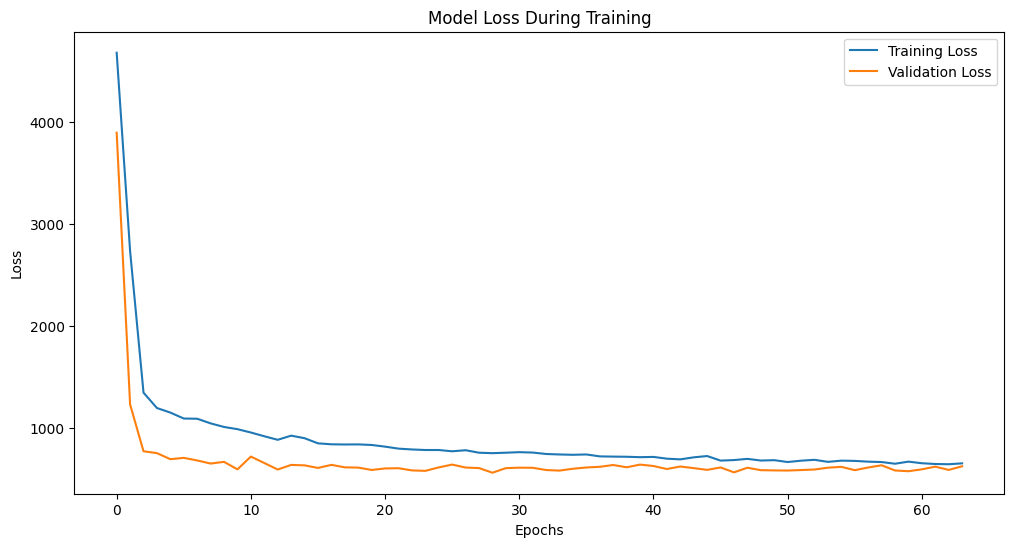

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss.png", dpi = 600, bbox_inches = "tight")
plt.show()

In [12]:
training_predictions = model.predict(x_train)
validation_predictions = model.predict(x_val)

  1/235 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


## 4. Predict target sales and evaluate MAPE

In [13]:
# DataFrames für Plots aktualisieren
train_predictions_df = pd.DataFrame({
    'Datum': train_data['Datum'],
    'id': train_data['id'],
    'Tatsächlicher Umsatz': y_train,
    'Vorhergesagter Umsatz': training_predictions.flatten()
})

val_predictions_df = pd.DataFrame({
    'Datum': val_data['Datum'],
    'id': val_data['id'],
    'Tatsächlicher Umsatz': y_val,
    'Vorhergesagter Umsatz': validation_predictions.flatten()
})

In [14]:
# Mapping für Warengruppen
ware_mapping = {
    1: 'Brot',
    2: 'Broetchen',
    3: 'Croissant',
    4: 'Konditorei',
    5: 'Kuchen',
    6: 'Saisonbrot'
}

# Spalte 'Datum' und 'Warengruppe' extrahieren
train_predictions_df['Datum'] = pd.to_datetime(train_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
train_predictions_df['Warengruppe'] = train_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
train_predictions_df['Jahr'] = train_predictions_df['Datum'].dt.year

# Spalte 'Datum' und 'Warengruppe' extrahieren
val_predictions_df['Datum'] = pd.to_datetime(val_predictions_df['id'].astype(str).str[:6], format='%y%m%d')
val_predictions_df['Warengruppe'] = val_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
val_predictions_df['Jahr'] = val_predictions_df['Datum'].dt.year

# MAPE für jede Warengruppe berechnen
def calculate_mape(y_true, y_pred):#(actual, predicted):
    #non_zero_mask = actual != 0
    #return (abs(actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask]).mean() * 100
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

print(f"MAPE on the Training Data: {calculate_mape(train_predictions_df['Tatsächlicher Umsatz'], train_predictions_df['Vorhergesagter Umsatz']):.2f}%")
for group in train_predictions_df['Warengruppe'].unique():
    group_data = train_predictions_df[train_predictions_df['Warengruppe'] == group]
    mape = calculate_mape(group_data['Tatsächlicher Umsatz'], group_data['Vorhergesagter Umsatz'])
    print(f"MAPE für {group}: {mape:.2f}%")


print(f"\n MAPE on the Validation Data: {calculate_mape(val_predictions_df['Tatsächlicher Umsatz'], val_predictions_df['Vorhergesagter Umsatz']):.2f}%")
for group in val_predictions_df['Warengruppe'].unique():
    group_data = val_predictions_df[val_predictions_df['Warengruppe'] == group]
    mape = calculate_mape(group_data['Tatsächlicher Umsatz'], group_data['Vorhergesagter Umsatz'])
    print(f"MAPE für {group}: {mape:.2f}%")

MAPE on the Training Data: 16.26%
MAPE für Brot: 18.06%
MAPE für Broetchen: 10.87%
MAPE für Croissant: 16.15%
MAPE für Konditorei: 20.43%
MAPE für Kuchen: 11.89%
MAPE für Saisonbrot: 41.35%

 MAPE on the Validation Data: 19.22%
MAPE für Brot: 19.55%
MAPE für Broetchen: 13.53%
MAPE für Croissant: 20.67%
MAPE für Konditorei: 22.66%
MAPE für Kuchen: 15.68%
MAPE für Saisonbrot: 44.82%


## 5. Plot predictions for training and validation data

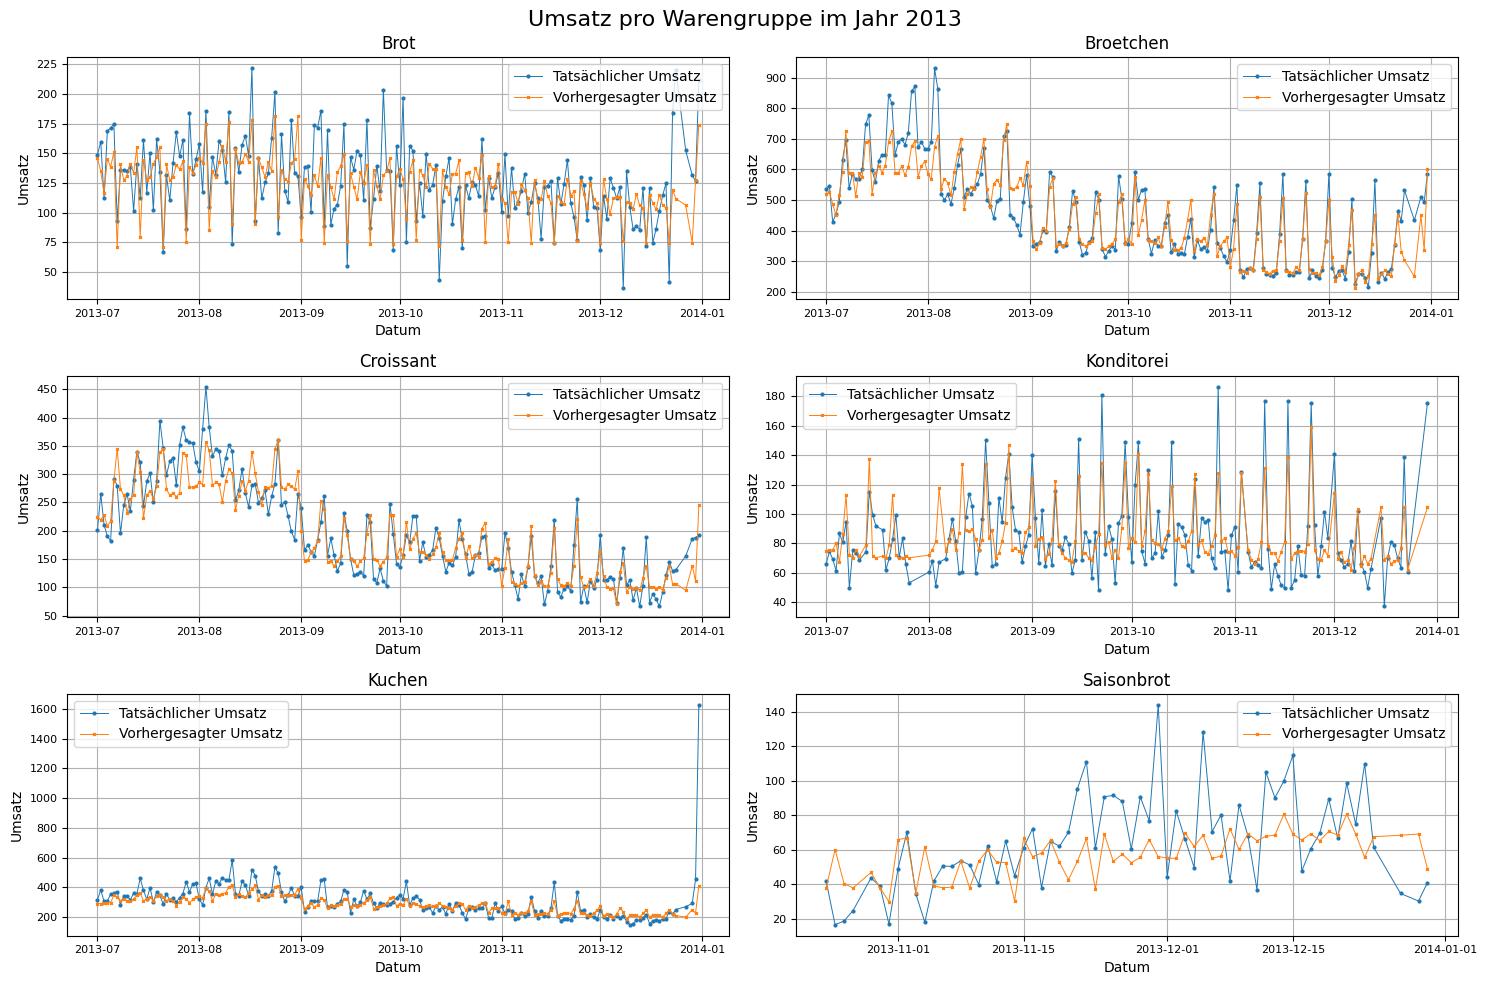

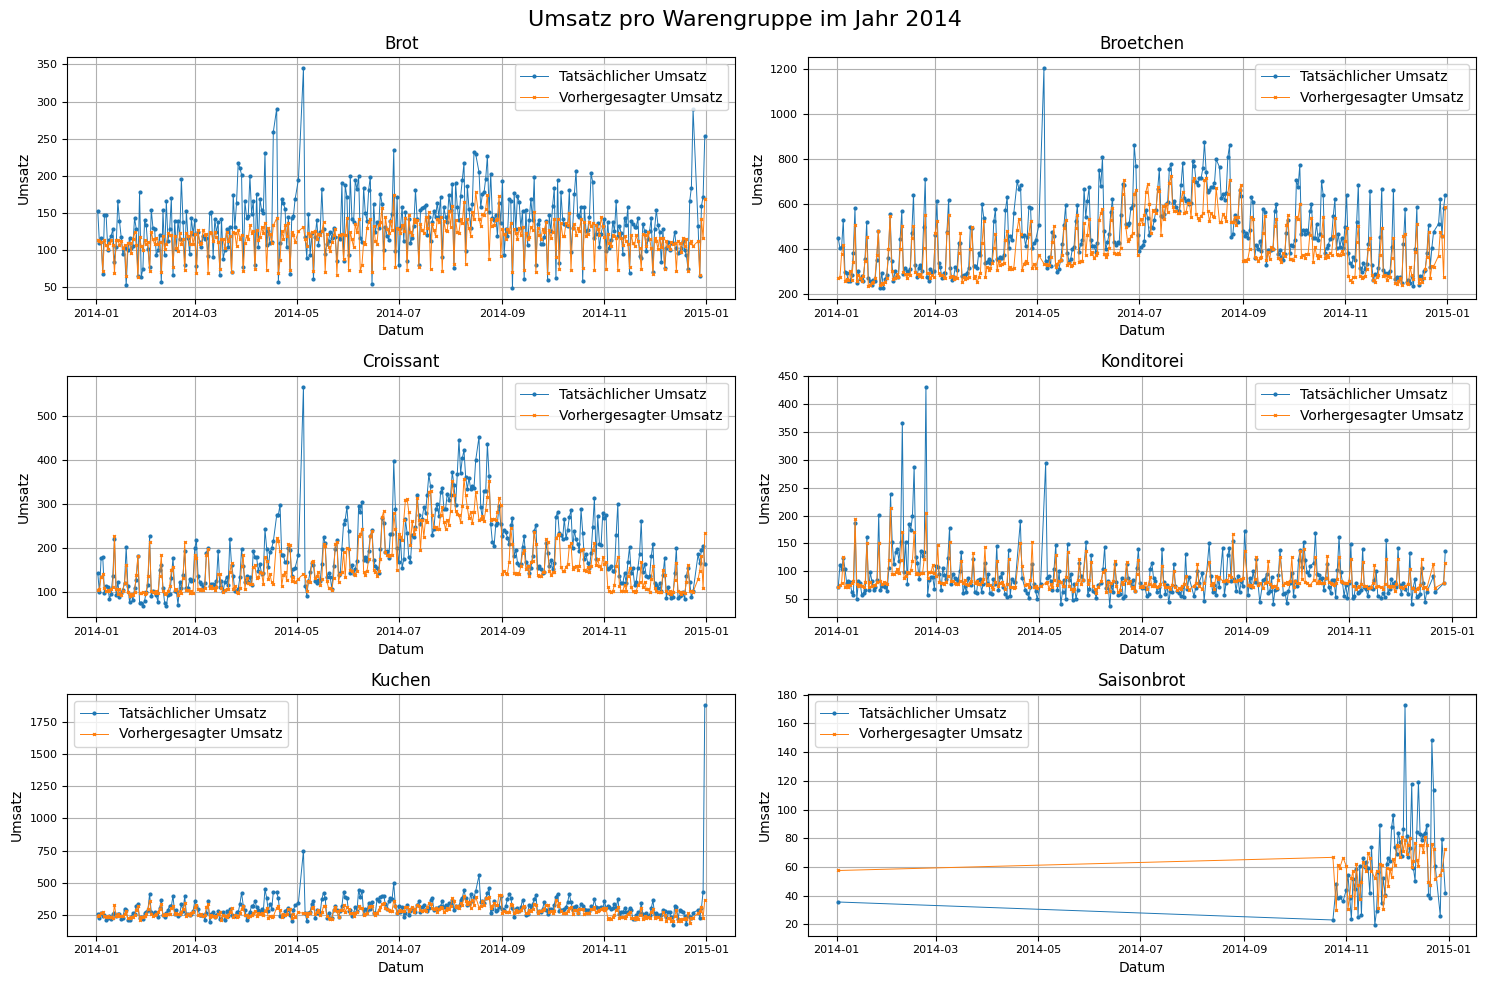

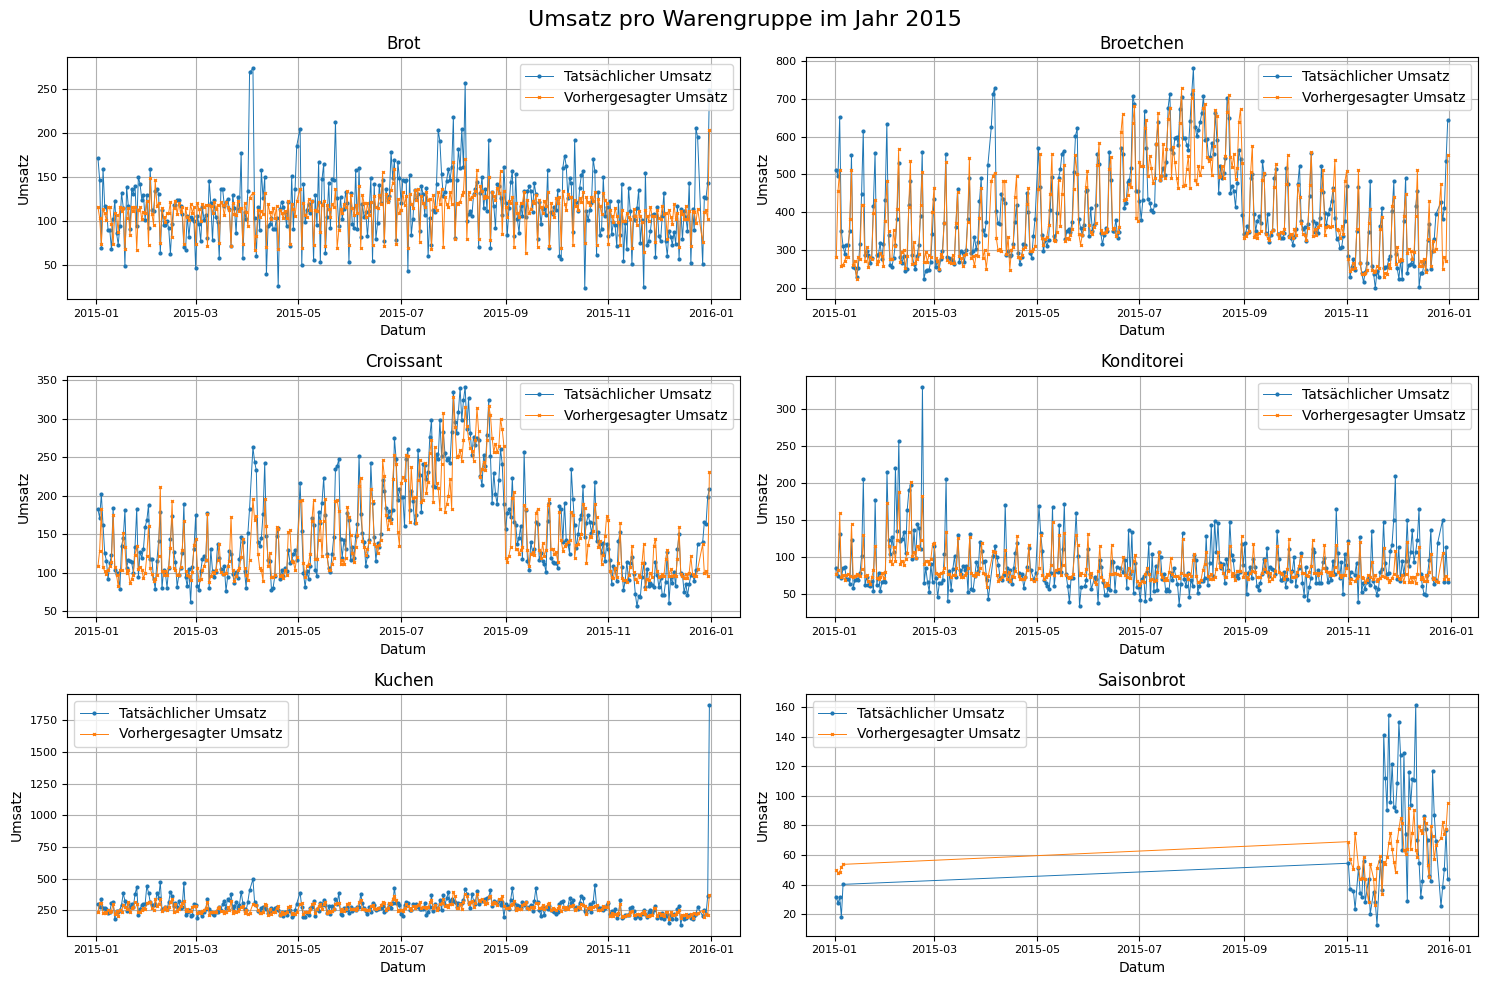

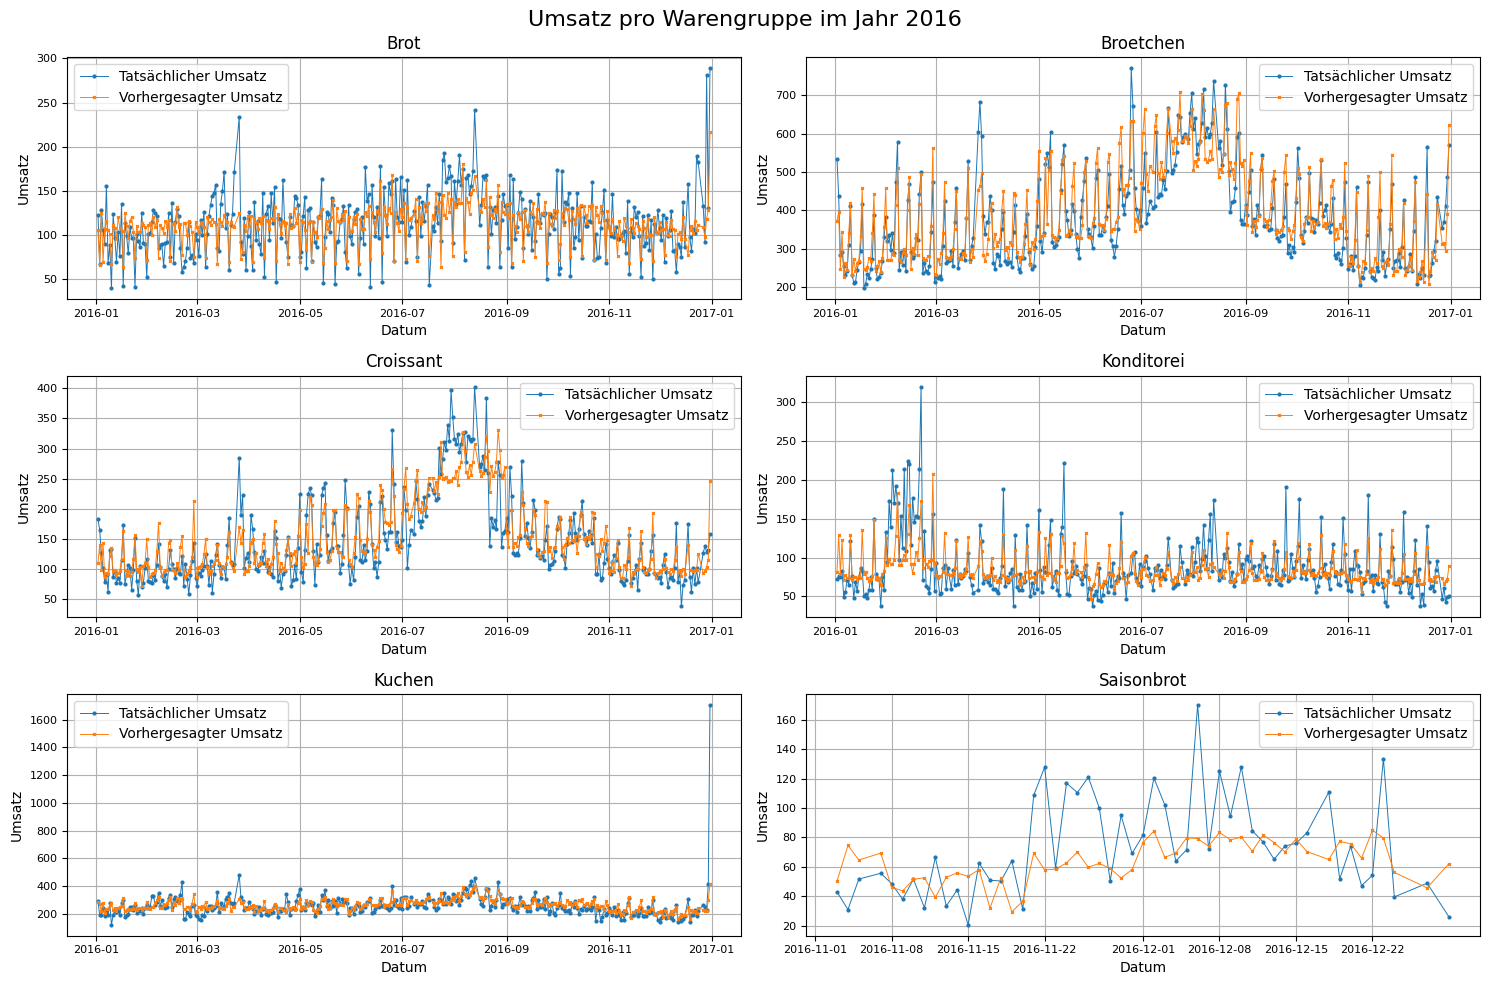

/tmp/ipykernel_75936/4152093079.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


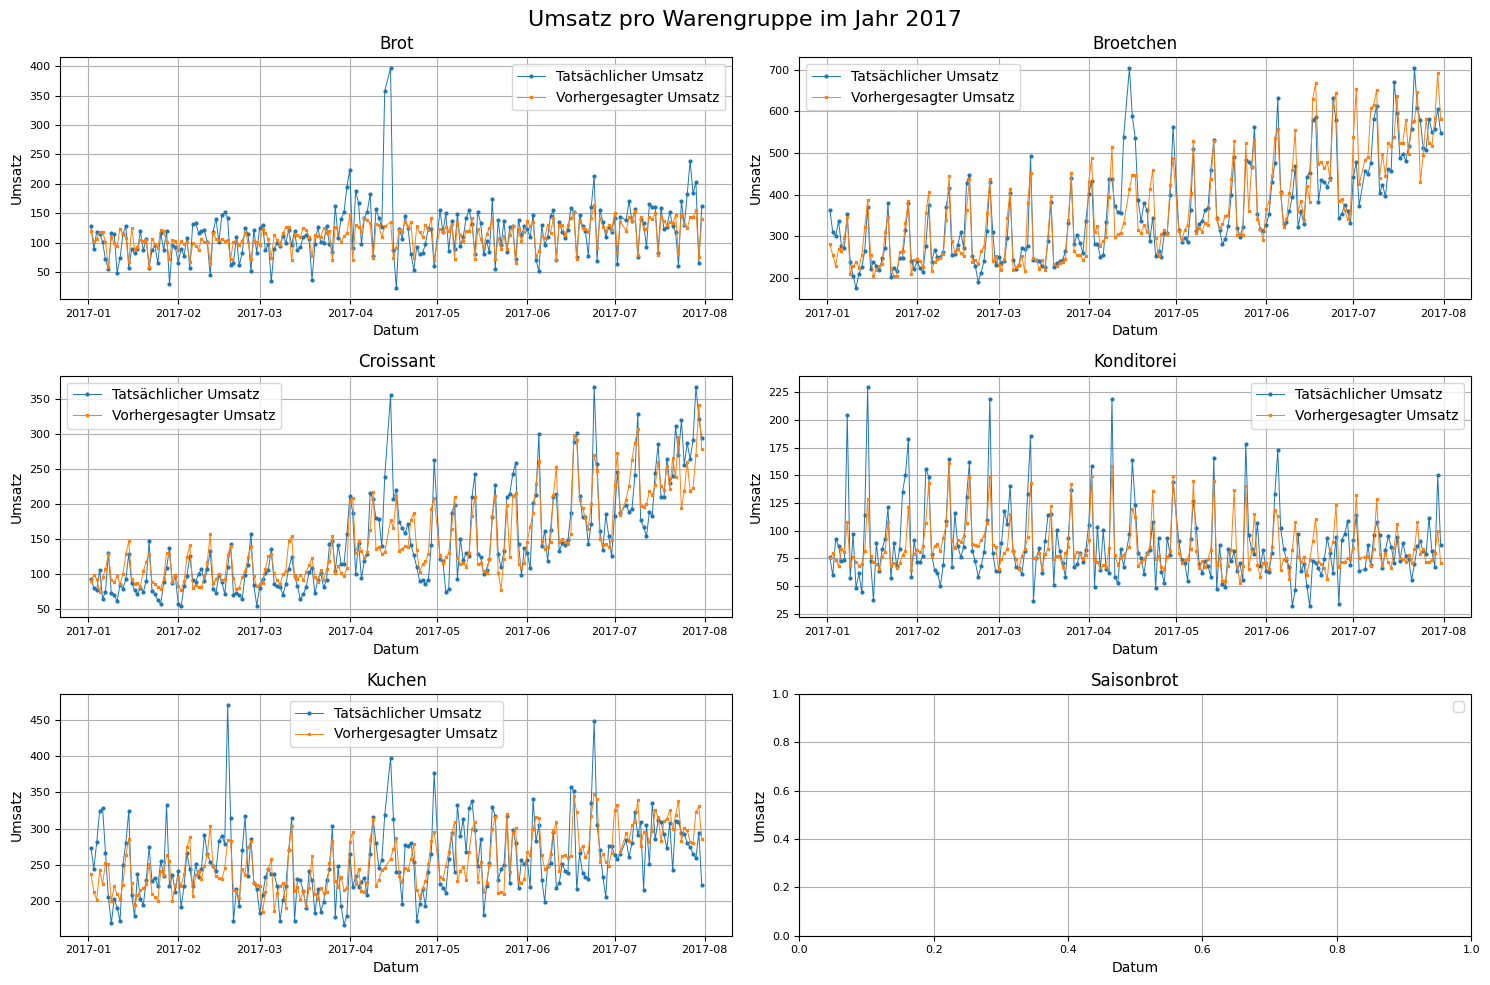

In [42]:
def plot_yearly_sales(df):
    # Liste der Jahre und Warengruppen
    years = sorted(df['Jahr'].unique())
    ware_groups = df['Warengruppe'].unique()

    # Anzahl der Subplots pro Figur (2 Spalten und 3 Zeilen)
    nrows, ncols = 3, 2

    for year in years:
        # Neue Figur für jedes Jahr erstellen
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
        fig.suptitle(f'Umsatz pro Warengruppe im Jahr {year}', fontsize=16)

        # Iterator für die Achsen
        axes = axes.flatten()

        for i, ware_group in enumerate(ware_groups):
            ax = axes[i]
            
            # Daten für die aktuelle Warengruppe und das Jahr filtern
            data = df[(df['Jahr'] == year) & (df['Warengruppe'] == ware_group)]

            if not data.empty:
                ax.plot(data['Datum'], data['Tatsächlicher Umsatz'], label='Tatsächlicher Umsatz', marker='o', markersize=2, linewidth=0.7)
                ax.plot(data['Datum'], data['Vorhergesagter Umsatz'], label='Vorhergesagter Umsatz', marker='x', markersize=2, linewidth=0.7)

            # Titel und Achsenbeschriftungen setzen
            ax.set_title(ware_group)
            ax.set_xlabel('Datum')
            ax.set_ylabel('Umsatz')
            ax.legend()
            ax.grid(True)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        # Entferne leere Subplots
        for j in range(len(ware_groups), len(axes)):
            fig.delaxes(axes[j])

        # Layout anpassen
        plt.tight_layout(rect=[0, 0, 1, 1.005])
        plt.savefig("umsatz_train_%s.pdf"%year, dpi = 600, bbox_inches = "tight")
        plt.show()

plot_yearly_sales(train_predictions_df)

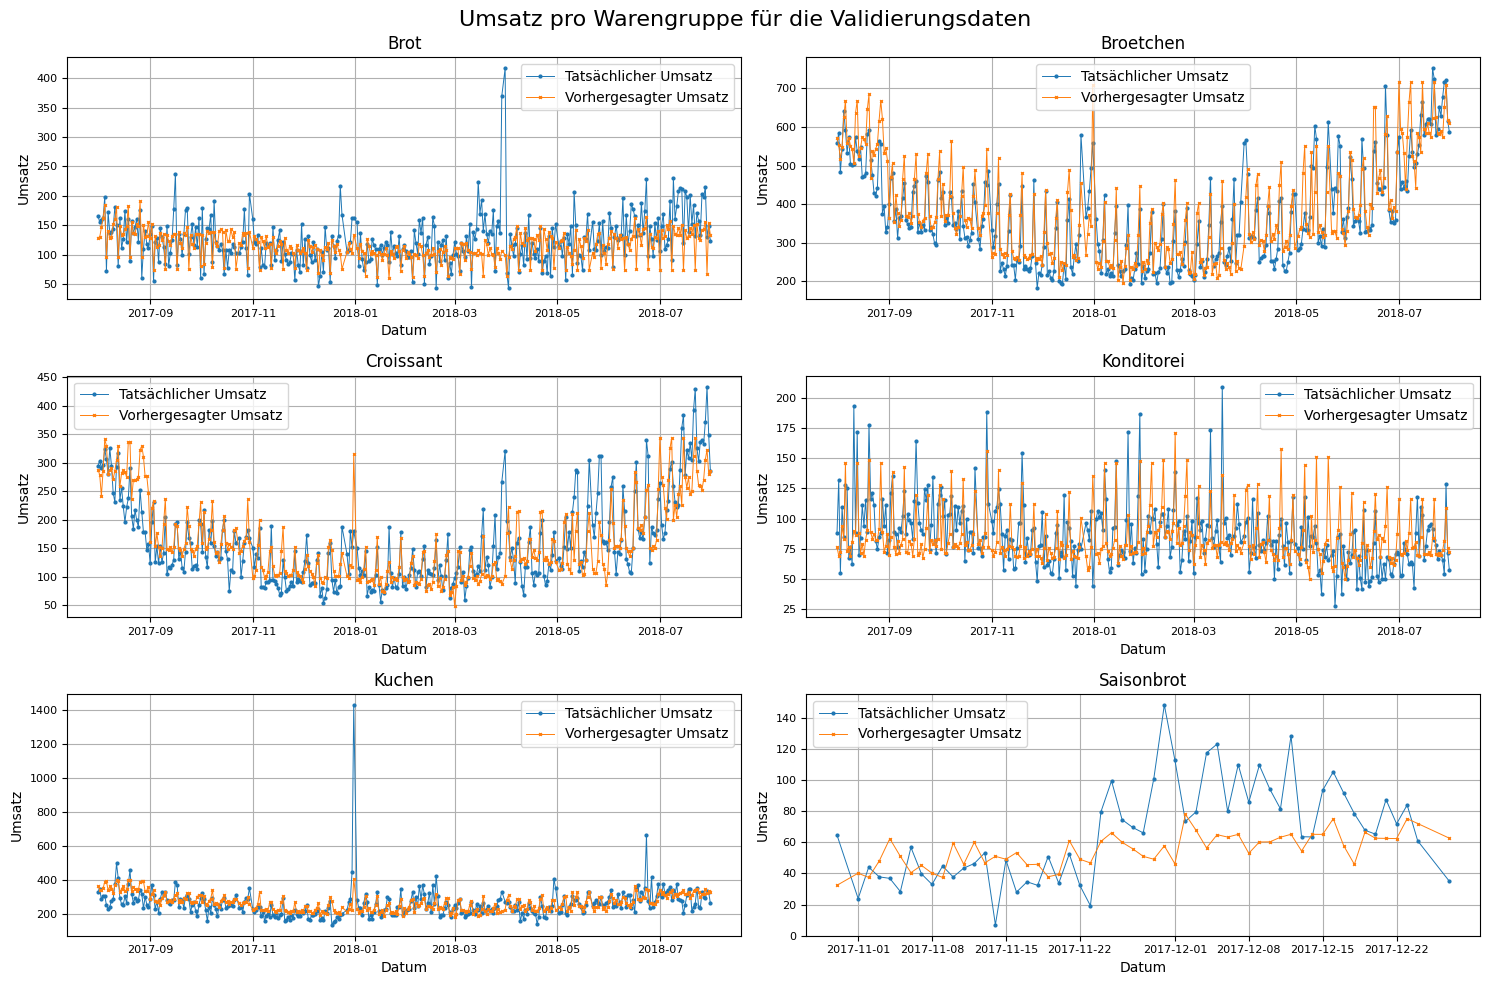

In [44]:
def plot_yearly_sales(df):
    # Liste der Jahre und Warengruppen
    years = sorted(df['Jahr'].unique())
    ware_groups = df['Warengruppe'].unique()

    # Anzahl der Subplots pro Figur (2 Spalten und 3 Zeilen)
    nrows, ncols = 3, 2

    #for year in years:
    # Neue Figur für jedes Jahr erstellen
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    fig.suptitle(f'Umsatz pro Warengruppe für die Validierungsdaten', fontsize=16)

    # Iterator für die Achsen
    axes = axes.flatten()

    for i, ware_group in enumerate(ware_groups):
        ax = axes[i]
        
        # Daten für die aktuelle Warengruppe und das Jahr filtern
        data = df[df['Warengruppe'] == ware_group]

        if not data.empty:
            ax.plot(data['Datum'], data['Tatsächlicher Umsatz'], label='Tatsächlicher Umsatz', marker='o', markersize=2, linewidth=0.7)
            ax.plot(data['Datum'], data['Vorhergesagter Umsatz'], label='Vorhergesagter Umsatz', marker='x', markersize=2, linewidth=0.7)

        # Titel und Achsenbeschriftungen setzen
        ax.set_title(ware_group)
        ax.set_xlabel('Datum')
        ax.set_ylabel('Umsatz')
        ax.legend()
        ax.grid(True)
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    # Entferne leere Subplots
    for j in range(len(ware_groups), len(axes)):
        fig.delaxes(axes[j])

    # Layout anpassen
    plt.tight_layout(rect=[0, 0, 1, 1.005])
    plt.savefig("umsatz_val.png", dpi = 600, bbox_inches = "tight")
    plt.show()

plot_yearly_sales(val_predictions_df)

## 6. Read test data set and create predictions for Kaggle competition

In [45]:
# load data
data = pd.read_csv("../0_DataPreparation/Data/model_test_20180801_20190730.csv")

# convert dates
data['Datum'] = pd.to_datetime(data['Datum'])
data

,id,Datum,Umsatz,KielerWoche,weekend_or_holiday,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel,...,Monat_May,Monat_November,Monat_October,Monat_September,is_Montag,is_Dienstag,is_Mittwoch,is_Donnerstag,is_Freitag,is_Samstag
0,1808011,2018-08-01,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1808021,2018-08-02,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1808031,2018-08-03,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1808041,2018-08-04,NaN,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1808051,2018-08-05,NaN,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,1812226,2018-12-22,NaN,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1826,1812236,2018-12-23,NaN,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1827,1812246,2018-12-24,NaN,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1828,1812276,2018-12-27,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [46]:
x_test = data[features]
y_test = data[target]

test_predictions = model.predict(x_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [47]:
# Mapping für Warengruppen
ware_mapping = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6
}

test_predictions_df = pd.DataFrame({
    'id': data['id'],
    'Datum': data['Datum'],
})

test_predictions_df['Warengruppe'] = test_predictions_df['id'].astype(str).str[-1].astype(int).map(ware_mapping)
test_predictions_df['Umsatz'] = test_predictions.flatten()

test_predictions_df.to_csv('test_predictions_group6_schwalowski_hintringer_kremin_20180801_20190730.csv', index=False)
test_predictions_df

,id,Datum,Warengruppe,Umsatz
0,1808011,2018-08-01,1,129.406967
1,1808021,2018-08-02,1,143.666946
2,1808031,2018-08-03,1,141.042038
3,1808041,2018-08-04,1,185.469528
4,1808051,2018-08-05,1,93.321678
...,...,...,...,...
1825,1812226,2018-12-22,6,76.403183
1826,1812236,2018-12-23,6,67.313728
1827,1812246,2018-12-24,6,63.811962
1828,1812276,2018-12-27,6,61.301231


In [7]:
# load data
data = pd.read_csv("test_predictions_group6_schwalowski_hintringer_kremin_20180801_20190730.csv")

data = data.drop(columns = ["Datum", "Warengruppe"])
data.to_csv('test_predictions_group6_schwalowski_hintringer_kremin_20180801_20190730.csv', index=False)
data

,id,Umsatz
0,1808011,129.406970
1,1808021,143.666950
2,1808031,141.042040
3,1808041,185.469530
4,1808051,93.321680
...,...,...
1825,1812226,76.403180
1826,1812236,67.313730
1827,1812246,63.811962
1828,1812276,61.301230


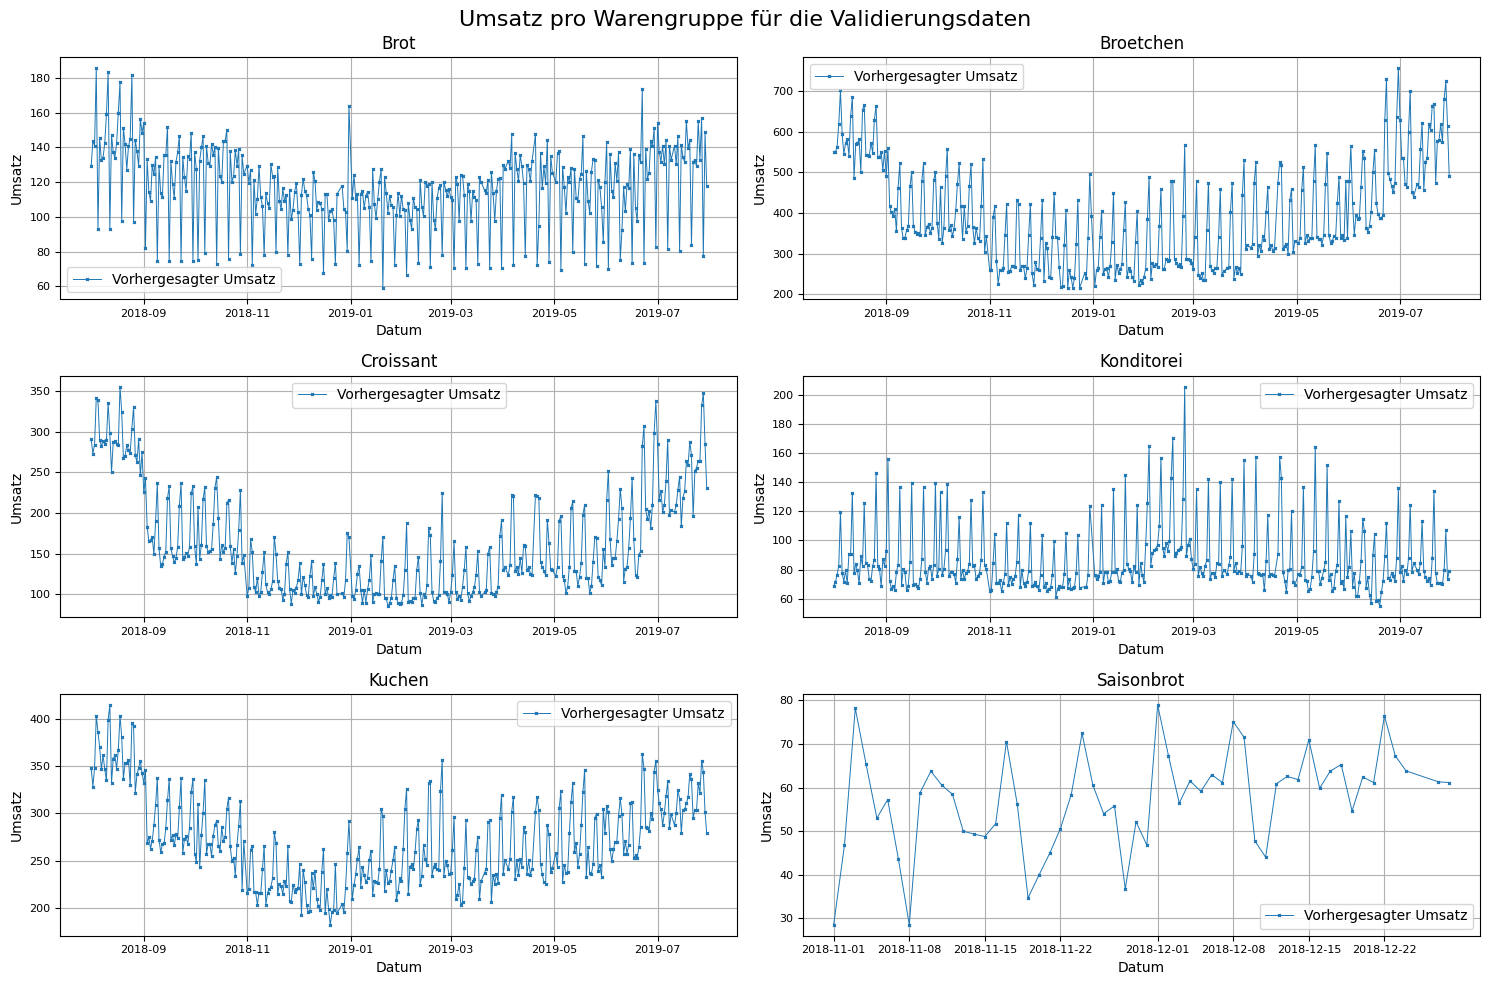

In [4]:
# load data
data = pd.read_csv("test_predictions_group6_schwalowski_hintringer_kremin_20180801_20190730.csv")

# convert dates
data['Datum'] = pd.to_datetime(data['Datum'])

def plot_yearly_sales(df):
    # Liste der Jahre und Warengruppen
    years = sorted(df['Jahr'].unique())
    ware_groups = df['Warengruppe'].unique()

    # Anzahl der Subplots pro Figur (2 Spalten und 3 Zeilen)
    nrows, ncols = 3, 2

    #for year in years:
    # Neue Figur für jedes Jahr erstellen
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    fig.suptitle(f'Umsatz pro Warengruppe für die Validierungsdaten', fontsize=16)

    # Iterator für die Achsen
    axes = axes.flatten()

    for i, ware_group in enumerate(ware_groups):
        ax = axes[i]
        
        # Daten für die aktuelle Warengruppe und das Jahr filtern
        data = df[df['Warengruppe'] == ware_group]

        if not data.empty:
            
            #ax.plot(data['Datum'], data['Tatsächlicher Umsatz'], label='Tatsächlicher Umsatz', marker='o', markersize=2, linewidth=0.7)
            ax.plot(data['Datum'], data['Umsatz'], label='Vorhergesagter Umsatz', marker='x', markersize=2, linewidth=0.7)

        # Titel und Achsenbeschriftungen setzen
        ax.set_title(ware_group)
        ax.set_xlabel('Datum')
        ax.set_ylabel('Umsatz')
        ax.legend()
        ax.grid(True)
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    # Entferne leere Subplots
    for j in range(len(ware_groups), len(axes)):
        fig.delaxes(axes[j])

    # Layout anpassen
    plt.tight_layout(rect=[0, 0, 1, 1.005])
    plt.savefig("umsatz_val.png", dpi = 600, bbox_inches = "tight")
    plt.show()


# Mapping für Warengruppen
ware_mapping = {
    1: 'Brot',
    2: 'Broetchen',
    3: 'Croissant',
    4: 'Konditorei',
    5: 'Kuchen',
    6: 'Saisonbrot'
}

# Spalte 'Datum' und 'Warengruppe' extrahieren
#data['Datum'] = pd.to_datetime(data['id'].astype(str).str[:6], format='%y%m%d')
data['Warengruppe'] = data['id'].astype(str).str[-1].astype(int).map(ware_mapping)
data['Jahr'] = data['Datum'].dt.year

plot_yearly_sales(data)